In [0]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

In [0]:
batch_size = 64
epochs = 35
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUM_CLASSES = 10
TRAIN_SET_SIZE = 2500
MODEL_ADDITION_DELTA = 0.01
MODEL_NAME = "MNIST_bagging"
PATH = ""

# Set seeds

In [0]:
np.random.seed(1)
tf.random.set_seed(1)

# Preprocess

In [0]:
def preprocess(imgs):
    
    processed = []
    
    for img in tqdm(imgs):
        processed.append(cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation = cv2.INTER_AREA))
    
    proccessed = np.array(processed)
    return proccessed.reshape(proccessed.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT, 1)

In [30]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Decrease the training set size
idx = np.random.choice(len(x_train), size=TRAIN_SET_SIZE, replace=False)
x_train = x_train[idx]
y_train = y_train[idx]

x_train = preprocess(x_train)
x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

100%|██████████| 10000/10000 [00:00<00:00, 149617.03it/s]

x_train shape: (2500, 32, 32, 1)
2500 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Model

In [0]:
def create_model():
    conv_base = VGG16(input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, 1),
                            include_top = False, weights = None, classes=NUM_CLASSES)

    conv_base.trainable = True

    model = Sequential()

    model.add(conv_base)
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_accuracy']
              )
    
    return model

# Predict

In [0]:
def predict(models):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(x_test), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(y_test, axis=1))

# Train

In [36]:
models = []
accuracies = [0]

for i in count(1):

    print(f"Train model {i}")
    idx = np.random.choice(len(x_train), size=len(x_train), replace=True)

    x_train_model = x_train[idx]
    y_train_model = y_train[idx]

    model = create_model()
    
    es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', min_delta=0.01, patience=3)
    model.fit(x_train_model,y_train_model,
              batch_size = batch_size,
              epochs = epochs,
              validation_data = (x_test,y_test),
              shuffle = True,
              callbacks=[es])
    models.append(model)

    acc = predict(models)
    delta = abs(acc - accuracies[-1])

    accuracies.append(acc)

    print(f"Model: {i} added. Resulting score: {acc}, Delta: {delta}")

    if delta <= MODEL_ADDITION_DELTA:
      break;

Train model 1
Train on 2500 samples, validate on 10000 samples
Epoch 1/35
2500/2500 [==============================] - 4s 2ms/step - loss: 2.1595 - categorical_accuracy: 0.1868 - val_loss: 1.3445 - val_categorical_accuracy: 0.5841
Epoch 2/35
2500/2500 [==============================] - 4s 1ms/step - loss: 1.0434 - categorical_accuracy: 0.6312 - val_loss: 0.8517 - val_categorical_accuracy: 0.6982
Epoch 3/35
2500/2500 [==============================] - 4s 1ms/step - loss: 0.6617 - categorical_accuracy: 0.7756 - val_loss: 0.5502 - val_categorical_accuracy: 0.8226
Epoch 4/35
2500/2500 [==============================] - 4s 1ms/step - loss: 0.4725 - categorical_accuracy: 0.8268 - val_loss: 0.9420 - val_categorical_accuracy: 0.7249
Epoch 5/35
2500/2500 [==============================] - 4s 1ms/step - loss: 0.3486 - categorical_accuracy: 0.8828 - val_loss: 0.2958 - val_categorical_accuracy: 0.9018
Epoch 6/35
2500/2500 [==============================] - 4s 1ms/step - loss: 0.1835 - categorical_

100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


Model: 1 added. Resulting score: 0.9415, Delta: 0.9415
Train model 2
Train on 2500 samples, validate on 10000 samples
Epoch 1/35
2500/2500 [==============================] - 4s 2ms/step - loss: 2.2369 - categorical_accuracy: 0.1524 - val_loss: 1.8873 - val_categorical_accuracy: 0.3821
Epoch 2/35
2500/2500 [==============================] - 4s 1ms/step - loss: 1.2431 - categorical_accuracy: 0.5572 - val_loss: 0.8566 - val_categorical_accuracy: 0.7004
Epoch 3/35
2500/2500 [==============================] - 3s 1ms/step - loss: 0.6545 - categorical_accuracy: 0.7656 - val_loss: 0.7223 - val_categorical_accuracy: 0.7569
Epoch 4/35
2500/2500 [==============================] - 4s 1ms/step - loss: 0.4713 - categorical_accuracy: 0.8212 - val_loss: 0.5743 - val_categorical_accuracy: 0.8052
Epoch 5/35
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3174 - categorical_accuracy: 0.8892 - val_loss: 0.3001 - val_categorical_accuracy: 0.9099
Epoch 6/35
2500/2500 [====================

100%|██████████| 2/2 [00:04<00:00,  2.45s/it]

Model: 2 added. Resulting score: 0.9421, Delta: 0.0006000000000000449


# Results

# Accuracy

In [37]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Round", accuracy_df.index + 1)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Round
0,0.0000,1
1,0.9415,2
2,0.9421,3


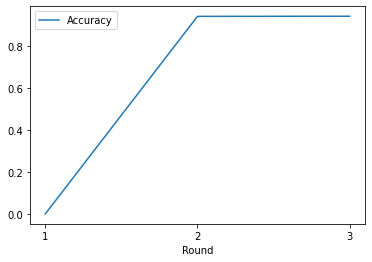

In [38]:
import matplotlib.pyplot as plt

accuracy_df.plot(x="Round", y="Accuracy", xticks=accuracy_df["Round"])
plt.show()

## Correlation between models

In [41]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))

100%|██████████| 2/2 [00:04<00:00,  2.43s/it]


In [42]:
correlation_matrix = []

for ix, x in enumerate(predictions):
  row = []
  
  for iy, y in enumerate(predictions):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
display(pd.DataFrame(correlation_matrix))
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

,0,1
0,NaN,0.935303
1,0.935303,NaN


Average correlation: 0.9353025570233877
